In [1]:
from collections import deque
import os
import random
from typing import Dict

import gymnasium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
from ray import tune, air
from ray.tune import JupyterNotebookReporter
from ray.tune.logger import TBXLoggerCallback
from ray.rllib.algorithms import AlgorithmConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import Episode, RolloutWorker
from ray.rllib.evaluation.episode_v2 import EpisodeV2
from ray.rllib.models.modelv2 import ModelV2
from ray.rllib.policy import Policy
from ray.rllib.utils.annotations import override
from ray.rllib.utils.framework import get_variable
from ray.rllib.utils.exploration.exploration import Exploration
from ray.rllib.utils.exploration.random import Random
from scipy.special import softmax
import seaborn as sns
import torch

from stocktradingv2.agent.mysac import MySAC, MySACConfig
from stocktradingv2.env.MultiStockTradingEnv import MultiStockTradingEnv

In [2]:
ray.init(ignore_reinit_error=True)

2023-03-15 14:13:21,428	WARNING utils.py:640 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2023-03-15 14:13:21,567	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.8.10
Ray version:,2.3.0


In [4]:
# Setup random seed
SEED = 114
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
dfs = []
norm_dict = {}
for root, dirs, files in os.walk("./datasets/SSE50/"):
    for file in files:
        path = os.path.join("./datasets/SSE50/", file)
        df = pd.read_csv(path)
        tic = file.split(".")[0]
        norm_dict[tic] = {}
        for col in df.columns:
            if col != "date" and col != "change":
                mean = df[col].mean()
                std = df[col].std()
                norm_dict[tic][col] = (mean, std)
                df[col] = (df[col] - mean) / std
        df["tic"] = tic
        dfs.append((file, df))

In [5]:
np.random.shuffle(dfs)
# Pick several stocks randomly to form a portfolio
dfs = dfs[:10]
tics = " ".join([tic for tic, df in dfs])
print(tics)

601628.SS.csv 601166.SS.csv 600030.SS.csv 600111.SS.csv 600028.SS.csv 600276.SS.csv 601857.SS.csv 600048.SS.csv 601398.SS.csv 600036.SS.csv


In [6]:
test_start = '2017-01-01'
trade_start = '2020-01-01'
test_start = pd.to_datetime(test_start, format='%Y-%m-%d')
trade_start = pd.to_datetime(trade_start, format='%Y-%m-%d')

# split
dfs_train = []
dfs_test = []
dfs_trade = []
for tic, df in dfs:
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df_train = df.loc[df.date < test_start].sort_index(ascending=True).copy()
    df_test = df.loc[(df.date >= test_start) & (df.date < trade_start)].sort_index(ascending=True).copy()
    df_trade = df.loc[df.date >= trade_start].sort_index(ascending=True).copy()
    dfs_train.append(df_train)
    dfs_test.append(df_test)
    dfs_trade.append(df_trade)

# ensemble
def ensemble(dfs_t):
    dfs_t = pd.concat(dfs_t)
    # drop dates that missing data
    dfs_t = dfs_t.pivot_table(index=['date'], columns=['tic']).dropna().stack().reset_index()
    dfs_t.sort_values(['date', 'tic'], inplace=True)
    dfs_t.set_index(['date', 'tic'], inplace=True)
    # print(dfs_t.head(5))
    return dfs_t

dfs_train = ensemble(dfs_train)
dfs_test = ensemble(dfs_test)
dfs_trade = ensemble(dfs_trade)
dfs_train.head()

cci    change     close    cr-ma1    cr-ma2    cr-ma3  \
date       tic                                                                  
2008-01-04 600028  0.891217  0.084145  0.111248 -0.036180 -0.038733 -0.041534   
           600030  0.531851  4.105417  0.028456  0.675933  0.707440  0.785949   
           600036 -0.289434  1.239447 -0.201373  0.983510  1.031276  1.140823   
           600048  0.895265  6.017374 -0.081115 -1.134979 -1.194946 -1.319297   
           600111 -0.205257  2.233212 -0.260045 -0.458192 -0.474707 -0.510644   

                       high    kdjj_9       low      open       ppo      ppoh  \
date       tic                                                                  
2008-01-04 600028  0.120257  0.865201  0.189359  0.134484  0.102169  0.037506   
           600030 -0.012022  0.704860 -0.034453 -0.136636  0.051929  0.058243   
           600036 -0.261869 -0.352393 -0.230817 -0.316123 -0.053209 -0.003870   
           600048 -0.086628  1.229594 -0.190580 -0.229146  0.003833  0.108724   
           600111 -0.277779  0.132512 -0.280125 -0.328223 -0.066062 -0.005398   

                       ppos  stochrsi    volume  
date       tic                                   
2008-01-04 600028  0.096538 -1.354270  0.145689  
           600030  0.036222  1.396025 -0.333455  
           600036 -0.055171  1.387650 -0.270492  
           600048 -0.031894  1.400567  0.476755  
           600111 -0.068099  1.456216 -0.165099

In [7]:
# Bootstrap strategy
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

c = dfs_train.change.reset_index().pivot_table(index="date", columns=["tic"])
c.columns = [col[-1] for col in c.columns.values]
c /= 100
c.insert(loc=0, column="cash", value=0.)
actions = []
# Window size
w = 250

for i in range(1, len(c)):
    window = c.iloc[max(0, i - w):i]
    mu = mean_historical_return(window, returns_data=True)
    S = CovarianceShrinkage(window, returns_data=True).ledoit_wolf()
    ef = EfficientFrontier(mu, S)
    # Use min volatility strategy
    weights = ef.min_volatility()
    actions.append(weights)
    
# Order dict from pypfopt to np.array list
a_list = []
for action in actions:
    a_list.append(np.array([v for k, v in action.items()]))

all_cash = np.zeros((11,))
all_cash[0] = 1.0
a_list = [all_cash] * (len(c) - len(a_list)) + a_list

/root/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/root/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/root/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/root/miniconda3/lib/python3.8/site-packages/sklearn/covariance/_shrunk_covariance.py:229: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/covariance/_empirical_covariance.py:86: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(


In [8]:
# df_t = dfs_train.reset_index()
# feature_matrix = df_t[[col for col in df_t.columns if col not in ["date", "tic"]]]
# num_tickers = len(df_t["tic"].unique())
# feature_dims = len(df_t.columns) - 2  # exclude date and tic
# feature_matrix = feature_matrix.to_numpy().reshape(-1, num_tickers, feature_dims)
# partial_obs = [state_t.flatten() for state_t in feature_matrix]

In [9]:
class Bootstrap(Exploration):
    def __init__(
        self,
        action_space: gymnasium.spaces.Space,
        *,
        framework: str,
        model: ModelV2,
        random_timesteps: int = 0,
        bootstrap_timesteps: int = 0,
        bootstrap_strategy = None,
        **kwargs,
    ):
        """Use timestep to index bootstap stategy from a list, 
        so it only support single rollout worker.

        """
        assert framework is not None
        super().__init__(action_space, model=model, framework=framework, **kwargs)

        # Create the Random exploration module (used for the first n
        # timesteps).
        self.random_timesteps = random_timesteps
        self.random_exploration = Random(
            action_space, model=self.model, framework=self.framework, **kwargs
        )
        self.bootstrap_timesteps = bootstrap_timesteps
        self.bootstrap_strategy = deque(bootstrap_strategy[:-1])

        # The current timestep value (tf-var or python int).
        self.last_timestep = get_variable(
            np.array(0, np.int64),
            framework=self.framework,
            tf_name="timestep",
            dtype=np.int64,
        )

    @override(Exploration)
    def get_exploration_action(
        self,
        *,
        action_distribution,
        timestep = None,
        explore: bool = True
    ):
        # Set last timestep or (if not given) increase by one.
        self.last_timestep = (
            timestep if timestep is not None else self.last_timestep + 1
        )

        # Apply exploration.
        if explore:
            # Apply bootstrap strategy
            if self.last_timestep < self.bootstrap_timesteps:
                a = self.bootstrap_strategy[0]
                action = torch.from_numpy(a).to(self.device)
                logp = torch.zeros((action.size()[0],), dtype=torch.float32, device=self.device)
                self.bootstrap_strategy.rotate(-1)
            # Random exploration phase.
            elif self.last_timestep < self.random_timesteps:
                action, logp = self.random_exploration.get_torch_exploration_action(
                    action_distribution, explore=True
                )
            # Take a sample from our distribution.
            else:
                action = action_distribution.sample()
                logp = action_distribution.sampled_action_logp()

        # No exploration -> Return deterministic actions.
        else:
            # Test.
            raise NotImplementedError
            action = action_dist.deterministic_sample()
            logp = torch.zeros_like(action_dist.sampled_action_logp())

        return action, logp

In [10]:
class MyCallbacks(DefaultCallbacks):
    def __init__(self, legacy_callbacks_dict: Dict[str, callable] = None):
        self._eval_counter = 0
        self._train_counter = 0
        super().__init__(legacy_callbacks_dict)

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: EpisodeV2,
        env_index: int,
        **kwargs
    ):
        env = base_env.get_sub_environments()[env_index]

        episode.hist_data["asset_memory"] = env.asset_memory
        episode.hist_data["reward_memory"] = env.reward_memory
        episode.custom_metrics["win_count"] = env.win_count
        episode.custom_metrics["total_cost"] = env.total_cost
        episode.custom_metrics["final_asset"] = env.asset_memory[-1]

        # a = np.array(env.action_memory).transpose()
        # a = softmax(a, axis=0)
        # fig, ax = plt.subplots(figsize=(16, 7))
        # plt.stackplot(np.arange(a.shape[1]), a)
        
        # in_eval =  worker.policy_config["in_evaluation"]
        # dqn_type = worker.policy_config["q_model_config"]["type"]
        # if in_eval:
        #     fig.savefig(f"./{dqn_type}_{self._eval_counter}_{episode.episode_id:05d}.png")
        #     self._eval_counter += 1
        # else:
        #     if self._train_counter % 10 == 0:
        #         fig.savefig(f"./{dqn_type}_{self._train_counter}_{episode.episode_id:05d}.png")
        #     self._train_counter += 1

In [11]:
param_space = MySACConfig().to_dict()
param_space.update(
    {
        "framework": "torch",
        "num_gpus": 0.25,

        "env": "MultiStockTrading",
        "env_config": {
            "df": dfs_train,
        # "verbose": True,
        },

        "policy_model_config": {
            "lstm_dim": 64,
            "net_arch": [128, 128],
        },
        "q_model_config": {
            "type": "iqn",
            "lstm_dim": 64,
            "num_atoms": 50,
            "net_arch": [128, 128],
            "num_critics": 1,
            # cqn
            "vmin": -10.0,
            "vmax": 10.,
            # iqn
            "risk_distortion_measure": None,
            "cos_embedding_dim": 64,
        },
        
        #"training_intensity": 1,
        "train_batch_size": 256,
        "tau": 0.01,
        "target_network_update_freq": 1,
        "target_entropy": "auto",
        "n_step": 1,
        "grad_clip": 40,
        "min_sample_timesteps_per_iteration": 200,
        "num_steps_sampled_before_learning_starts": 256,
        "metrics_num_episodes_for_smoothing": 5,
        "num_steps_sampled_before_learning_starts": 256,

        "optimization": {
            "actor_learning_rate": 0.003,
            "critic_learning_rate": 0.003,
            "entropy_learning_rate": 0.003,
        },

        "exploration_config": {
            "type": Bootstrap,
            "random_timesteps": 0,
            "bootstrap_timesteps": 20000,
            "bootstrap_strategy": a_list,
        },

        "callbacks": MyCallbacks,
        # "evaluation_interval": 3,
        # "evaluation_duration": 1,
        # "evaluation_duration_unit": "episodes",
        # "evaluation_num_workers": 1,
        # "evaluation_config": {
        #     "explore": False,
        #     "env_config": {
        #         "df": dfs_test,
        #     },
        # }
    }
)
#param_space

In [12]:
tuner = tune.Tuner(
    MySAC, 
    param_space=param_space,
    tune_config=tune.TuneConfig(num_samples=1),
    run_config=air.RunConfig(
        name="bootstrap_exploration",
        progress_reporter=JupyterNotebookReporter(),
        stop={
            "episode_reward_mean": 10,
            "timesteps_total": 1000000,
        },
        callbacks=[TBXLoggerCallback()],
    )
)
results = tuner.fit()

E0315 14:13:53.501778522   17401 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(MySAC pid=18867) 2023-03-15 14:13:56,533	WARNING algorithm_config.py:596 -- Cannot create MySACConfig from given `config_dict`! Property __stdout_file__ not supported.
(MySAC pid=18867) 2023-03-15 14:13:56,719	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(MySAC pid=18867) 2023-03-15 14:13:56,747	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(MySAC pid=18867) 2023-03-15 14:13:56,747	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


(MySAC pid=18867) 2023-03-15 14:14:01,705	ERROR worker.py:772 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::MySAC.__init__() (pid=18867, ip=172.17.0.5, repr=MySAC)
(MySAC pid=18867)   File "/root/StockTradingV2/stocktradingv2/agent/mysac/my_sac.py", line 112, in __init__
(MySAC pid=18867)     super().__init__(*args, **kwargs)
(MySAC pid=18867)   File "/root/miniconda3/lib/python3.8/site-packages/ray/rllib/algorithms/sac/sac.py", line 344, in __init__
(MySAC pid=18867)     super().__init__(*args, **kwargs)
(MySAC pid=18867)   File "/root/miniconda3/lib/python3.8/site-packages/ray/rllib/algorithms/algorithm.py", line 445, in __init__
(MySAC pid=18867)     super().__init__(
(MySAC pid=18867)   File "/root/miniconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 169, in __init__
(MySAC pid=18867)     self.setup(copy.deepcopy(self.config))
(MySAC pid=18867)   File "/root/miniconda3/lib/python3.8/site-packages/

In [10]:
# result = results.get_best_result(metric="episode_reward_mean", mode="max")
# cp = result.best_checkpoints[0][0]
# algo = MySAC.from_checkpoint(cp)

# Baseline

In [75]:
env = MultiStockTradingEnv({"df": dfs_train})

In [76]:
done = False
obs = env.reset()
act = np.zeros((11,))
act[0] = 1.0
while not done:
    obs, reward, done, _, _ = env.step(act)
env.asset_memory[-1]

1.0

In [77]:
done = False
obs = env.reset()
act = np.ones((11,)) / 11
while not done:
    obs, reward, done, _, _ = env.step(act)
env.asset_memory[-1]

1.7646416990063771

In [78]:
c = dfs_train.change.reset_index().pivot_table(index="date", columns=["tic"])
c.columns = [col[-1] for col in c.columns.values]
c /= 100
# c += 1
# c = c.cumprod()
c.insert(loc=0, column="cash", value=0.)
c

,cash,600028,600031,600048,600196,600436,600519,600585,600809,601166,601628
date,,,,,,,,,,,
2008-01-04,0.0,0.000841,-0.007283,0.060174,-0.019231,-0.025193,0.005090,0.014140,-0.015249,0.017255,0.021265
2008-01-07,0.0,-0.008403,0.026375,0.004827,0.030719,-0.011604,-0.013520,0.007776,-0.016571,0.039448,-0.013587
2008-01-08,0.0,0.026271,-0.030973,-0.023584,-0.045657,-0.011206,0.012716,-0.029001,0.001934,0.031499,0.039893
2008-01-09,0.0,0.006606,-0.006849,0.036231,0.007309,0.029412,0.000047,0.010686,0.009098,0.009382,-0.018235
2008-01-10,0.0,-0.027892,0.012909,0.078417,-0.016491,-0.019659,0.009486,0.033347,0.024317,0.038455,0.024005
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,0.0,0.005319,0.014706,0.005476,0.012445,-0.006139,0.013905,0.001168,0.016964,0.002492,0.026260
2016-12-27,0.0,-0.019401,-0.004831,0.005447,0.001756,-0.003530,0.005177,-0.001166,0.006416,-0.003107,-0.009905
2016-12-28,0.0,-0.001799,-0.016181,-0.013001,0.003067,-0.004206,-0.007481,-0.015178,-0.002550,-0.001870,-0.005836


In [79]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [80]:
actions = []
asset_memory_list = []
action_hist_list = []
for w in [5, 10, 20 ,60, 120, 250]:
    for i in range(w, len(c)):
        window = c.iloc[i - w:i]
        mu = mean_historical_return(window, returns_data=True)
        S = CovarianceShrinkage(window, returns_data=True).ledoit_wolf()
        ef = EfficientFrontier(mu, S)
        weights = ef.min_volatility()
        actions.append(weights)

    a_list = []
    for action in actions:
        a_list.append(np.array([v for k, v in action.items()]))

    all_cash = np.zeros((11,))
    all_cash[0] = 1.0
    a_list = [all_cash] * (w - 1) + a_list
    action_hist_list.append(a_list)

    done = False
    i = 0
    obs = env.reset()
    while not done:
        obs, reward, done, _, _ = env.step(a_list[i])
        i += 1
    print(w, env.asset_memory[-1])
    asset_memory_list.append(env.asset_memory)

5 0.4518079769993535
10 1.2787236574689131
20 0.95141519141978
60 1.0113437220788146
120 1.2573375552823387
250 1.7630396464605473


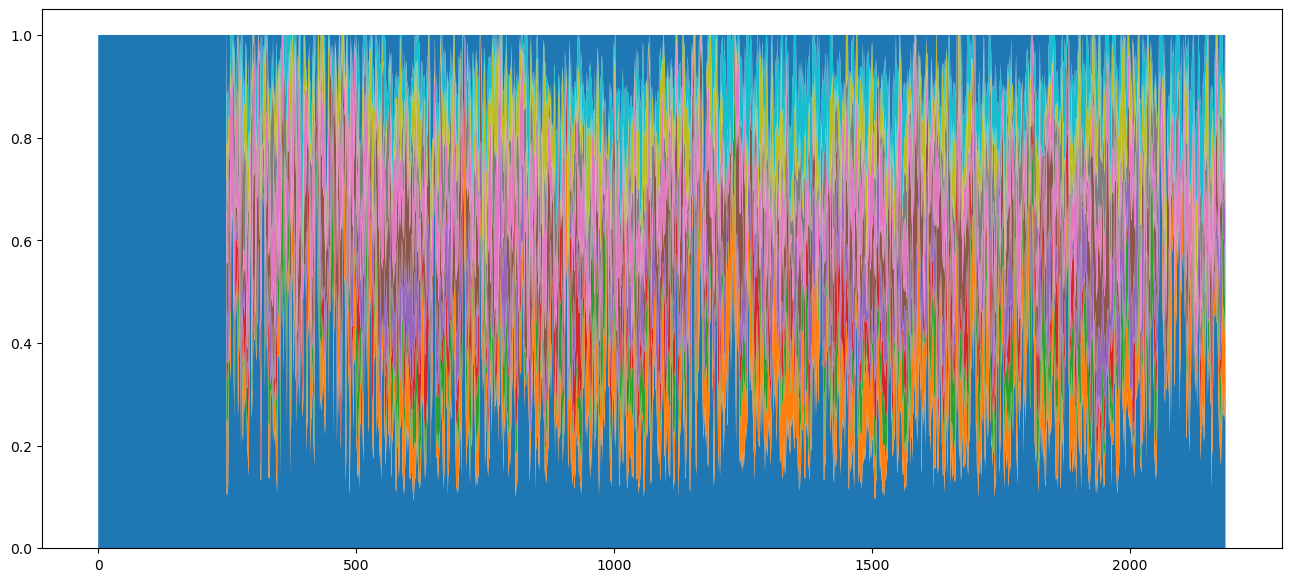

In [81]:
a = np.array(env.action_memory).transpose()
#a = softmax(a, axis=0)
fig, ax = plt.subplots(figsize=(16, 7))
plt.stackplot(np.arange(a.shape[1]), a)

In [82]:
actions = []
asset_memory_list = []
action_hist_list = []
for w in [5, 10, 20 ,60, 120, 250]:
    for i in range(w, len(c)):
        window = c.iloc[i - w:i]
        mu = mean_historical_return(window, returns_data=True)
        S = CovarianceShrinkage(window, returns_data=True).ledoit_wolf()
        ef = EfficientFrontier(mu, S, verbose=False)
        weights = ef.max_sharpe(mu.min() - 1e-5)
        actions.append(weights)

    a_list = []
    for action in actions:
        a_list.append(np.array([v for k, v in action.items()]))

    all_cash = np.zeros((11,))
    all_cash[0] = 1.0
    a_list = [all_cash] * (w - 1) + a_list
    action_hist_list.append(a_list)

    done = False
    i = 0
    obs = env.reset()
    while not done:
        obs, reward, done, _, _ = env.step(a_list[i])
        i += 1
    print(w, env.asset_memory[-1])
    asset_memory_list.append(env.asset_memory)

5 0.199513892616591
10 0.6973536502670112
20 0.1962033726766121
60 0.521317779718409
120 0.286065101468104
250 1.3732584341896479


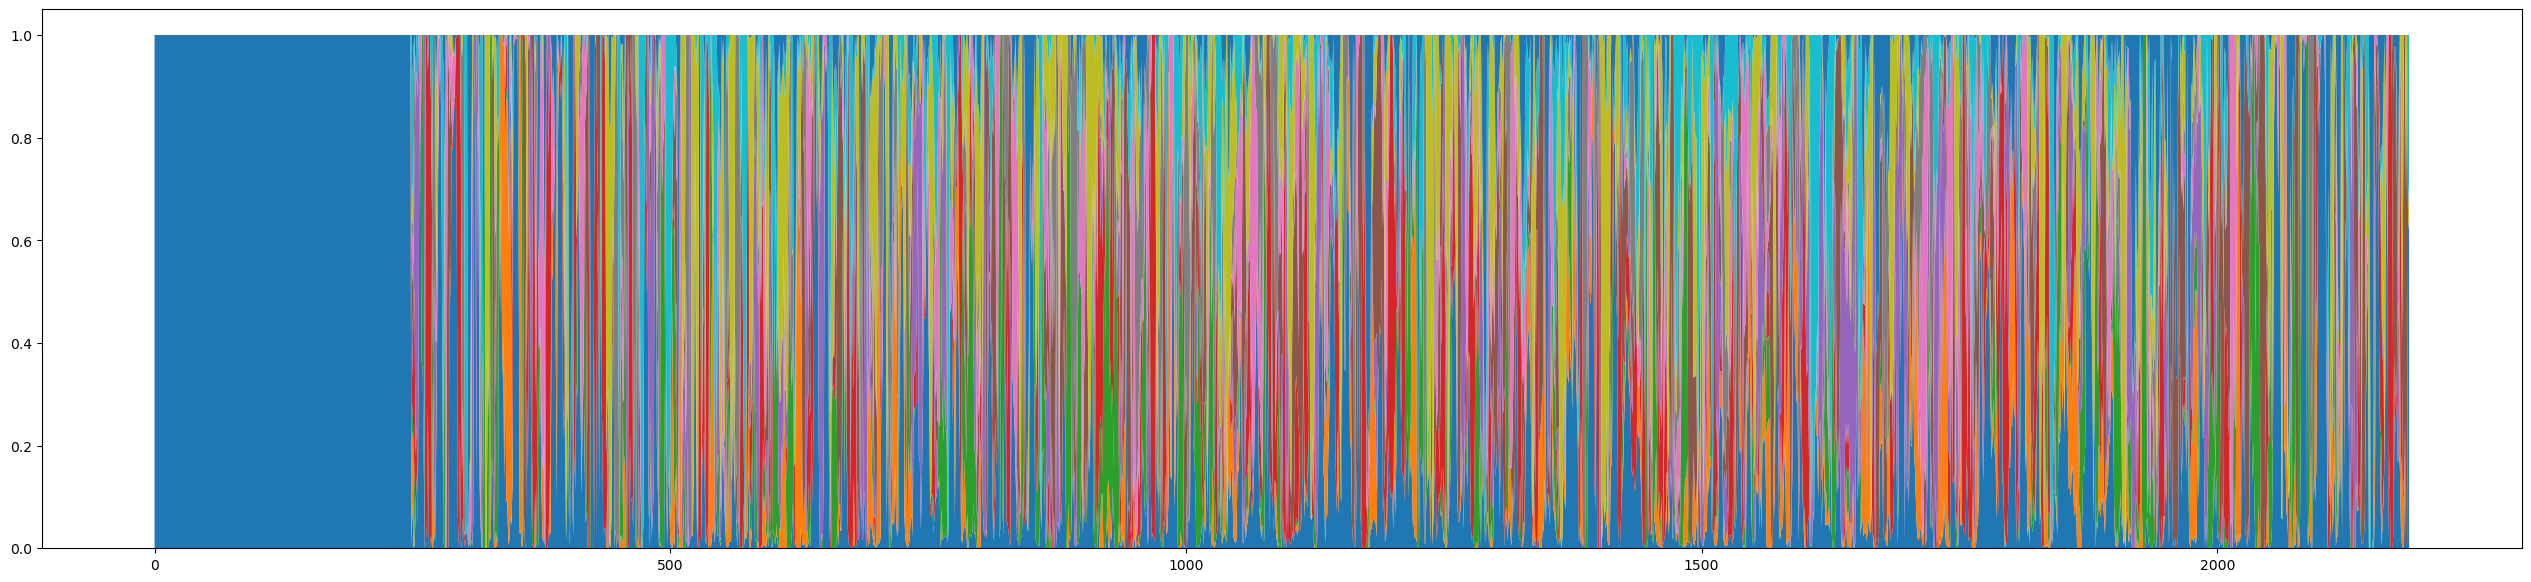

In [83]:
a = np.array(env.action_memory).transpose()
#a = softmax(a, axis=0)
fig, ax = plt.subplots(figsize=(32, 7))
plt.stackplot(np.arange(a.shape[1]), a)

In [84]:
a.sum(axis=0).max()

1.0000000000000002